In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle

In [4]:
plt.ion()
parismap = mpimg.imread('data/paris-48.806-2.23--48.916-2.48.jpg')

In [5]:
xmin,xmax = 2.23,2.48   
ymin,ymax = 48.806,48.916

In [6]:
def show_map():
    plt.imshow(parismap,extent=[xmin,xmax,ymin,ymax],aspect=1.5)

# Methode des histogrammes

In [7]:
def Histo(pas,xmin,xmax,ymin,ymax):
    arrayX=np.linspace(xmin,xmax,pas)
    arrayY=np.linspace(ymin,ymax,pas)
    return arrayX,arrayY

In [15]:
def MatHisto(arrayX,arrayY,geomat):
    n=len(arrayX)
    m=len(arrayY)
    mat=np.zeros((m,n))
    for coord in geomat:
        x=coord[1]
        y=coord[0]
        for i in range(n):
            if (arrayX[i]>x):
                posX=i
                break
        for i in range(m):
            if (arrayY[i]>y):
                posY=i
                break
        mat[posY,posX]+=1
    return mat

In [16]:
def show_Histo(geo_mat,steps,xmin,xmax,ymin,ymax):
    a, b = Histo(steps,xmin,xmax,ymin,ymax)
    res = MatHisto(a, b, geo_mat)
    plt.figure()
    show_map()
    res /= sum(sum(res))
    plt.scatter(geo_mat[:, 1], geo_mat[:, 0], alpha=0.2, s=3,c="blue",label=typepoi)
    plt.legend()
    plt.title("Méthode des histogrammes avec une discrétisation en {} intervalles".format(steps))
    plt.imshow(res, extent=[xmin, xmax, ymin, ymax], interpolation='none', \
               alpha=0.3, origin="lower")
    plt.colorbar()

In [17]:
poidata = pickle.load(open("data/poi-paris.pkl","rb"))
## liste des types de point of interest (poi)
print("Liste des types de POI" , ", ".join(poidata.keys()))

## Choix d'un poi
typepoi = "night_club"

## Creation de la matrice des coordonnees des POI
geo_mat = np.zeros((len(poidata[typepoi]),2))
print("{} points d'intérêt trouvés".format(len(poidata[typepoi])))

for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]

Liste des types de POI furniture_store, laundry, bakery, cafe, home_goods_store, clothing_store, atm, lodging, night_club, convenience_store, restaurant, bar
556 points d'intérêt trouvés


Text(0.5, 1.0, 'Affichage des POI')

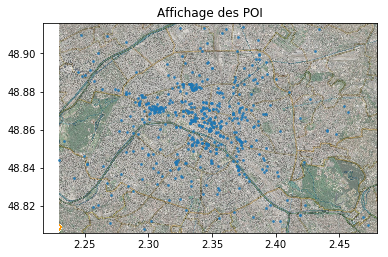

In [18]:
## Affichage brut des poi
show_map()
plt.scatter(geo_mat[:,1],geo_mat[:,0],alpha=0.8,s=3)
plt.title("Affichage des POI")

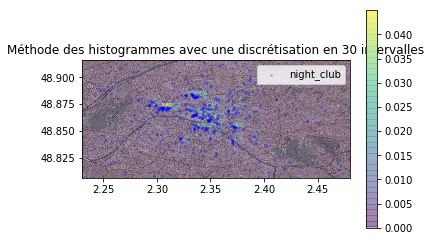

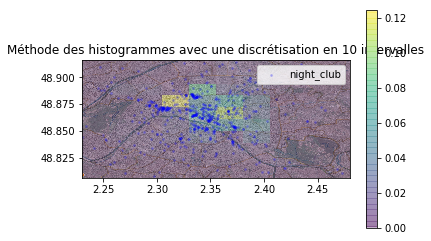

In [19]:
# discretisation pour l'affichage des modeles d'estimation de densite
steps = 50
xx,yy = np.meshgrid(np.linspace(xmin,xmax,steps),np.linspace(ymin,ymax,steps))
grid = np.c_[xx.ravel(),yy.ravel()]

show_Histo(geo_mat,30,xmin,xmax,ymin,ymax)
show_Histo(geo_mat,10,xmin,xmax,ymin,ymax)

Cet estimateur histogramme ĝn a un défaut majeur. Considérons la classe Cj = [αj, αj+1[, et imaginons que le point x ∈ Cj où l’on veut estimer la densité g(x) par ĝn(x), se situe près de l’extrémité αj. Alors, toutes les observations de la classe Cj interviennent dans le calcul de ĝn, mais on se rend compte qu’une observation située près de αj+1 sera prise en compte, alors qu’elle est assez éloignée de x, et qu’une observation située tout près de x dans la classe Cj−1 n’entre pas en ligne de compte dans le calcul de ĝn. Pour remédier à cet inconvénient, on peut alors utiliser l’histogramme mobile, qui est un translaté de l’histogramme de manière que l’observation x où l’on estime, se retrouve au centre d’une classe, plus précisément au centre de la classe [x − h, x + h[ où h désigne la demi-largeur d’une classe. 

# Methode des noyaux

ICI on va définir les différents types de noyaux que l'on peut utiliser

In [63]:
def Kernel_Uniform(v):
    r=1
    for c in v:
        if (abs(c)<=1):
            r*=0.5
        else:
            return 0
    return r

In [64]:
def Kernel_Epanechikov(v):
    r=1
    for c in v:
        r*=0.75*max(0,1-c**2)
    return r

In [65]:
def Kernel_Gauss(v):
    return np.prod((1/np.sqrt(2*np.pi))*np.exp(-0.5*v**2),axis=0)

In [66]:
def Kernel_Laplace(v):
    return np.prod(0.5*np.exp(-1*abs(v)))

In [67]:
def genere_Data(d,p):
    if p<=0 or p>=1:
        return
    np.random.shuffle(d)
    c=int(len(d)*p)
    train=d[:c]
    test=d[c:]
    return train,test


La fonction Mat_Kernel discrérise l'espace étudié (grid). Pour chaque valeur v de grid (l'espace discrétisé), la fonction va calculer la valeur du noyau  entre la valeur v et chacun des points de l'ensemble de données geo_mat.

In [68]:
def Mat_Kernel(grid,geomat,f,h):
    n=len(geomat)
    m=np.zeros((len(grid)))
    for i in range(len(grid)):
        e=np.array([grid[i][1],grid[i][0]])
        for c in geomat: 
            v=f((c-e)/h)
            m[i]+=v
        m[i] *= 1/(n*h)
    m /= sum(m)
    return m

La fonction Search permet de retourver les coordonnées d'un point dans l'espace discrétisé. Si on veut estimer la densité en ce point, il nous faut trouver à quelle région de l'espace ce point appartient.

In [69]:
def Search(X,Y,p,steps):
    px=p[1]
    py=p[0]
    steps = len(X)
    x=steps-1
    y=steps-1
    for i in range (steps):
        e = X[i]
        if e>px:
            x = i
            break
    for i in range (steps):
        e = Y[i]
        if e>py:
            y = i
            break
    return (y,x)

In [70]:
def Mat_K(grid,train,f,h):
    m = np.zeros((len(grid)))
    n = len(train)
    for i in range(len(grid)):
        e = np.array([grid[i][1], grid[i][0]])
        for c in train:
            m[i] += f((c - e) / h)
        m[i] *= 1 / (n * h)
    m = m.reshape((steps, steps))
    if (sum(sum(m)) != 0 ):
        m /= sum(sum(m))
    return m

La focntion Vraissemblance va nous permettre de calculer la vraissemblance.

In [71]:
def Vraissemblance(m,test,X,Y,steps):
    l=0
    for e in test:
        (x,y) = Search(X,Y,e,steps)
        v = m[x][y]
        if v == 0:
            l += np.log(0.000000001)
        else:
            l += np.log(v)
    return l

In [72]:
def Kernel_Show(geo_mat,f,h,steps):
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
    grid = np.c_[xx.ravel(), yy.ravel()]
    m = Mat_Kernel(grid,geo_mat, f, h)
    m = m.reshape((steps, steps))
    m /= sum(sum(m))
    plt.figure()
    show_map()
    plt.scatter(geo_mat[:, 1], geo_mat[:, 0], alpha=0.8, s=3,label=typepoi)
    plt.legend()
    plt.title("Noyau: {}, h: {}".format(f.__name__,h))
    plt.imshow(m, extent=[xmin, xmax, ymin, ymax], interpolation='none', alpha=0.3, origin="lower")
    plt.colorbar()
    return

On va faire varier la valeur de la fenêtre pour observer l'impact de ce paramètre sur la variation de l'estimaiton de la densité

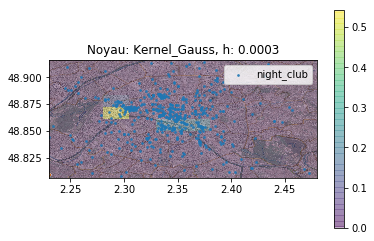

In [73]:
Kernel_Show(geo_mat, Kernel_Gauss, 0.0003, steps)

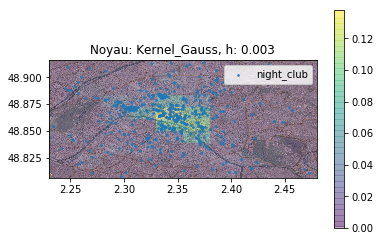

In [74]:
Kernel_Show(geo_mat, Kernel_Gauss, 0.003, steps)

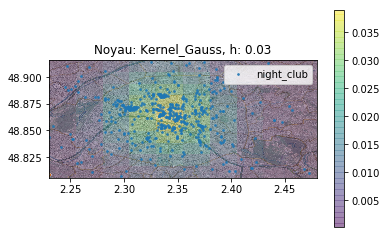

In [75]:
Kernel_Show(geo_mat, Kernel_Gauss, 0.03, steps)

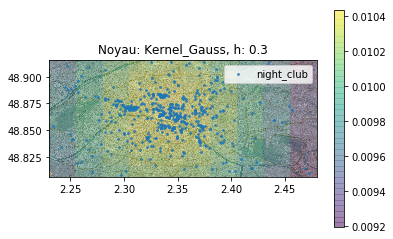

In [76]:
Kernel_Show(geo_mat, Kernel_Gauss, 0.3, steps)

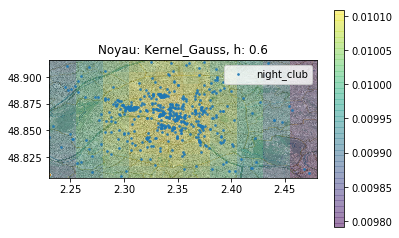

In [77]:
Kernel_Show(geo_mat, Kernel_Gauss, 0.6, steps)

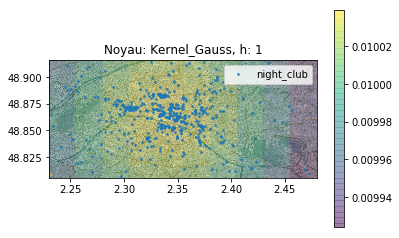

In [78]:
Kernel_Show(geo_mat, Kernel_Gauss, 1, steps)

Observations:

On constate que plus la valeurs de h augmente, plus la tache jaune au milieu s'élargie. Je penses que, lorsque la tâche jaune s'élargit, cela veut dire que la distrubition de la densité prend de plus en plus l'allure d'une distribution de loi normale.

Pour des h trop petits, par exemple pour h=0.0003, on peut voir que l'ensemble de la map est colorié en violet. Ainsi, la densité associé à chacun des points de geo_mat, est au plus bas sur l'échelle de densité( Je parle de l'échelle indiqué par le plt.colorbar() ).

Par contre, pour des valeurs de h plus grande ( exemple :0.6), on peut voir que la couleur jaune qui correspond au maximum de la densité sur l'échelle, est présente sur une grande majorité de la map (surtout au millieu).

Ainsi, plus la valeur de h augmente, plus la couleur jaune prend de l'espace sur la map. Et ainsi, plus la couleur jaune prend de l'espace sur la map, plus il y aura de points associé au maximum de densité sur l'échelle indiqué.

De plus on remarque aussi que pour des valeurs de h différentes, l'échelle de densité n'est pas la même. Ainsi, dans la partie qui suit, on va chercher à trouver la valeur de la fenêtre qui nous donne la meilleur estimations de densité.
Pour cela on va calculer le maximum de vraissemblance.

In [79]:
def Optimise_H(H,geo_mat,p,f,steps):
    X = np.linspace(xmin, xmax, steps)
    Y = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(X,Y)
    grid = np.c_[xx.ravel(), yy.ravel()]
    S = []
    
    for h in H:
        l = 0
        train, test = genere_Data(geo_mat, 0.6)
        m = Mat_K(grid, train, f, h)
        l += Vraissemblance(m, test, X, Y,steps)
        S.append(l)
        print("h:",h," log vraissemblance:",l)
        
    for j in range(4):
        St = np.argsort(-1 * np.array(S))
        bh = H[St[0]] # meilleur h trouvé
        sh = H[St[1]] # deuxième meilleur h trouvé
        print("Les deux meilleurs h sont: {} et {}".format(bh, sh))
        print("les deux meilleurs h trouvé sont:",bh," et ",sh)
        nh = (bh + sh) / 2  # on prend le milieu entre les eux
        if nh in H:
            continue
        print("On test avec le nouveau h :",nh)
        H.append(nh)
        train, test = genere_Data(geo_mat, 0.6)
        m = Mat_K(grid, train, f, nh)
        l += Vraissemblance(m, test, X, Y,steps)
        for i in range(p-1):
            train, test = genere_Data(geo_mat, 0.6)
            l += Vraissemblance(m, test, X, Y,steps)
        l /= p
        print("h:",nh,", log vraissemblance: ",l)
        S.append(l)
    bh = H[S.index(max(S))]
    print(" Le h qui maximise le calcul de la vraissemblance est:",bh)
    Kernel_Show(geo_mat, f, bh, steps)
    plt.show()


# Test

Etude de la vraissemblance des donnéees:

l'idée est de découper l'ensemble de points de geo_mat en deux ensemble (1 ensemble de train et un ensemble de test). Ensuite on discrétise l'espace pour calculer les densités à partir des points de l'ensemble train. Puis, pour chacun des points de l'ensemble de test, on va récupérer la valeur de la densité qui lui correspond à partir des densités calculé précedemment. Et on calcule la log vraissemblance en sommant le log des densité de chacunes des données de test. On répète ce processus pour plusieur valeurs de h , de sorte à identifier la fenêtre h pour laquelle la valeur du log vraissemblance est maximale. (une valeur maximale du log vraissemblance est associé au modèle dont l'estimation de densité se "colle" le plus au données , donc le meilleur modèle).

In [80]:
a=[i for i in np.arange(0.0001,0.0003,0.0001)]
b=[i for i in np.arange(0.001,0.003,0.001)]
c=[i for i in np.arange(0.01,0.03,0.01)]
d=[i for i in np.arange(0.1,1,0.1)]
H=a+b+c+d
steps=10

h: 0.0001  log vraissemblance: -4621.288281639038
h: 0.0002  log vraissemblance: -4621.288281639038
h: 0.001  log vraissemblance: -4422.579356433218
h: 0.002  log vraissemblance: -3690.591204836877
h: 0.01  log vraissemblance: -997.5867061348279
h: 0.02  log vraissemblance: -887.0354667442214
h: 0.1  log vraissemblance: -915.2745245407664
h: 0.2  log vraissemblance: -992.4410128901615
h: 0.30000000000000004  log vraissemblance: -1011.5387087786186
h: 0.4  log vraissemblance: -1018.6686291652785
h: 0.5  log vraissemblance: -1021.7293318740091
h: 0.6  log vraissemblance: -1023.439385982271
h: 0.7000000000000001  log vraissemblance: -1024.238296732448
h: 0.8  log vraissemblance: -1024.9442978636296
h: 0.9  log vraissemblance: -1025.3803575549687
Les deux meilleurs h sont: 0.02 et 0.1
les deux meilleurs h trouvé sont: 0.02  et  0.1
On test avec le nouveau h : 0.060000000000000005
h: 0.060000000000000005 , log vraissemblance:  -1384.5417483468468
Les deux meilleurs h sont: 0.02 et 0.1
les d

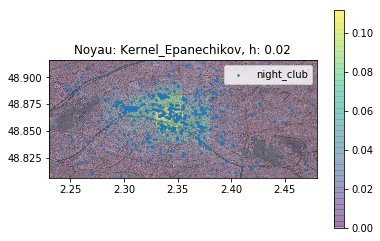

In [81]:
Optimise_H(H,geo_mat,2,Kernel_Epanechikov,steps)

h: 0.0001  log vraissemblance: -43029.194079086825
h: 0.0002  log vraissemblance: -38384.88158197923
h: 0.001  log vraissemblance: -3031.208169858035
h: 0.002  log vraissemblance: -1428.376289758297
h: 0.01  log vraissemblance: -903.6811126169937
h: 0.02  log vraissemblance: -848.4986946897301
h: 0.1  log vraissemblance: -974.7044274814003
h: 0.2  log vraissemblance: -1011.638920459213
h: 0.30000000000000004  log vraissemblance: -1020.1285610614145
h: 0.4  log vraissemblance: -1022.9504477905017
h: 0.5  log vraissemblance: -1024.3514229147152
h: 0.6  log vraissemblance: -1025.242433356178
h: 0.7000000000000001  log vraissemblance: -1025.680592773929
h: 0.8  log vraissemblance: -1025.9331359981988
h: 0.9  log vraissemblance: -1026.1428325676452
h: 0.060000000000000005  log vraissemblance: -931.836525970362
Les deux meilleurs h sont: 0.02 et 0.01
les deux meilleurs h trouvé sont: 0.02  et  0.01
On test avec le nouveau h : 0.015
h: 0.015 , log vraissemblance:  -1291.0561667122647
Les deux

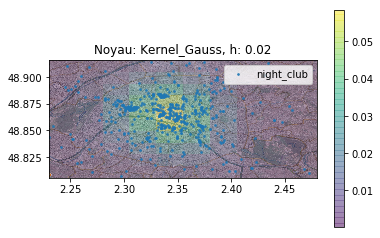

In [82]:
Optimise_H(H,geo_mat,2,Kernel_Gauss,steps)

h: 0.0001  log vraissemblance: -9648.974801659851
h: 0.0002  log vraissemblance: -5011.45643410303
h: 0.001  log vraissemblance: -1550.8860406104284
h: 0.002  log vraissemblance: -1023.4837199428111
h: 0.01  log vraissemblance: -850.7354232796114
h: 0.02  log vraissemblance: -850.3221864860218
h: 0.1  log vraissemblance: -947.4663032124055
h: 0.2  log vraissemblance: -982.7433263608582
h: 0.30000000000000004  log vraissemblance: -995.9348235653363
h: 0.4  log vraissemblance: -1003.6284415098847
h: 0.5  log vraissemblance: -1007.956928732091
h: 0.6  log vraissemblance: -1012.1757699290741
h: 0.7000000000000001  log vraissemblance: -1013.5216157819965
h: 0.8  log vraissemblance: -1015.3473851397514
h: 0.9  log vraissemblance: -1016.5362552177139
h: 0.060000000000000005  log vraissemblance: -908.1780352935725
h: 0.015  log vraissemblance: -833.6993268442014
Les deux meilleurs h sont: 0.015 et 0.02
les deux meilleurs h trouvé sont: 0.015  et  0.02
On test avec le nouveau h : 0.0175
h: 0.01

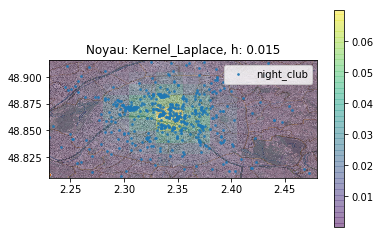

In [83]:
Optimise_H(H,geo_mat,2,Kernel_Laplace,steps)

h: 0.0001  log vraissemblance: -4621.288281639038
h: 0.0002  log vraissemblance: -4579.841749965145
h: 0.001  log vraissemblance: -4400.956976418786
h: 0.002  log vraissemblance: -4360.274741505303
h: 0.01  log vraissemblance: -1055.106540612399
h: 0.02  log vraissemblance: -870.6064097159939
h: 0.1  log vraissemblance: -958.1448253581166
h: 0.2  log vraissemblance: -1025.2150168256808
h: 0.30000000000000004  log vraissemblance: -1026.9529514753415
h: 0.4  log vraissemblance: -1026.9529514753415
h: 0.5  log vraissemblance: -1026.9529514753415
h: 0.6  log vraissemblance: -1026.9529514753415
h: 0.7000000000000001  log vraissemblance: -1026.9529514753415
h: 0.8  log vraissemblance: -1026.9529514753415
h: 0.9  log vraissemblance: -1026.9529514753415
h: 0.060000000000000005  log vraissemblance: -899.3925390585338
h: 0.015  log vraissemblance: -867.4732877321383
h: 0.0175  log vraissemblance: -930.7552186449917
Les deux meilleurs h sont: 0.015 et 0.02
les deux meilleurs h trouvé sont: 0.015 

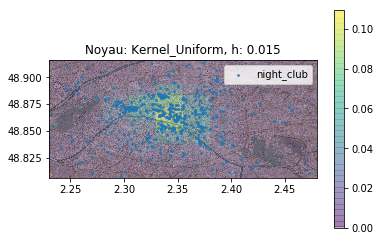

In [84]:
Optimise_H(H,geo_mat,2,Kernel_Uniform,steps)

# On va faire varier la valeur de steps

h: 0.0001  log vraissemblance: -31340.835591120125
h: 0.0002  log vraissemblance: -38190.87784855302
h: 0.001  log vraissemblance: -4244.69920637336
h: 0.002  log vraissemblance: -1555.7540837715403
h: 0.01  log vraissemblance: -833.9838830347464
h: 0.02  log vraissemblance: -849.7181712575311
h: 0.1  log vraissemblance: -975.3984243950649
h: 0.2  log vraissemblance: -1012.5019211091069
h: 0.30000000000000004  log vraissemblance: -1019.9324894587616
h: 0.4  log vraissemblance: -1023.023412355567
h: 0.5  log vraissemblance: -1024.4246073437669
h: 0.6  log vraissemblance: -1025.1200486299617
h: 0.7000000000000001  log vraissemblance: -1025.6506281721452
h: 0.8  log vraissemblance: -1025.9659451260939
h: 0.9  log vraissemblance: -1026.127993310519
h: 0.060000000000000005  log vraissemblance: -925.5809260381961
h: 0.015  log vraissemblance: -831.2957672469668
h: 0.0175  log vraissemblance: -834.4325037001427
Les deux meilleurs h sont: 0.015 et 0.01
les deux meilleurs h trouvé sont: 0.015  

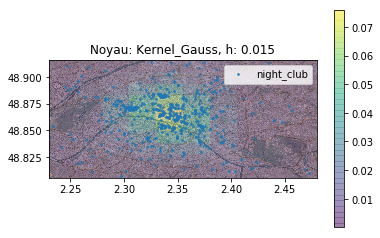

In [85]:
steps=10
Optimise_H(H,geo_mat,2,Kernel_Gauss,steps)

h: 0.0001  log vraissemblance: -10641.918880719746
h: 0.0002  log vraissemblance: -5065.047510955061
h: 0.001  log vraissemblance: -1606.2232719527397
h: 0.002  log vraissemblance: -1234.3508152711167
h: 0.01  log vraissemblance: -1121.1601989400237
h: 0.02  log vraissemblance: -1138.85376846127
h: 0.1  log vraissemblance: -1258.495046382915
h: 0.2  log vraissemblance: -1292.0208053244878
h: 0.30000000000000004  log vraissemblance: -1306.1668278969207
h: 0.4  log vraissemblance: -1313.4925873895754
h: 0.5  log vraissemblance: -1318.2684024286775
h: 0.6  log vraissemblance: -1320.6213371491338
h: 0.7000000000000001  log vraissemblance: -1323.439920957523
h: 0.8  log vraissemblance: -1324.6401323598684
h: 0.9  log vraissemblance: -1325.786272929943
h: 0.060000000000000005  log vraissemblance: -1222.5249599500016
h: 0.015  log vraissemblance: -1117.8215334546217
h: 0.0175  log vraissemblance: -1155.4237698521715
h: 0.0125  log vraissemblance: -1117.3794987193146
Les deux meilleurs h sont:

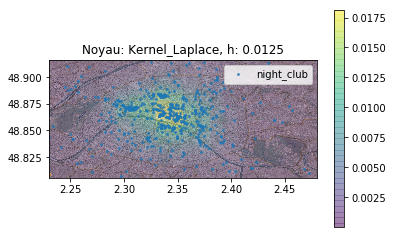

In [86]:
steps=20
Optimise_H(H,geo_mat,2,Kernel_Laplace,steps)

h: 0.0001  log vraissemblance: -9918.580103628568
h: 0.0002  log vraissemblance: -4707.230944741974
h: 0.001  log vraissemblance: -1556.7214014348579
h: 0.002  log vraissemblance: -1389.5190211923382
h: 0.01  log vraissemblance: -1280.0421476490426
h: 0.02  log vraissemblance: -1311.714669411655
h: 0.1  log vraissemblance: -1438.7285468760278
h: 0.2  log vraissemblance: -1475.6369319067153
h: 0.30000000000000004  log vraissemblance: -1487.5307511800195
h: 0.4  log vraissemblance: -1494.3925215845118
h: 0.5  log vraissemblance: -1499.2699586947251
h: 0.6  log vraissemblance: -1502.1750370391676
h: 0.7000000000000001  log vraissemblance: -1503.8848907736724
h: 0.8  log vraissemblance: -1505.5420659136348
h: 0.9  log vraissemblance: -1506.9495311973733
h: 0.060000000000000005  log vraissemblance: -1410.2289653787632
h: 0.015  log vraissemblance: -1314.826492317015
h: 0.0175  log vraissemblance: -1313.5570340048764
h: 0.0125  log vraissemblance: -1312.145132169844
h: 0.01375  log vraissemb

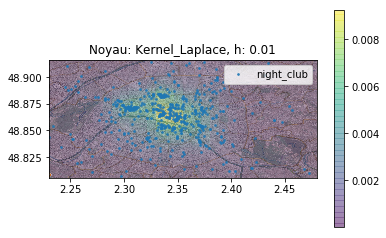

In [87]:
steps=30
Optimise_H(H,geo_mat,2,Kernel_Laplace,steps)

h: 0.0001  log vraissemblance: -9666.641216154598
h: 0.0002  log vraissemblance: -5825.187371330871
h: 0.001  log vraissemblance: -1746.7951501701434
h: 0.002  log vraissemblance: -1557.6570002657954
h: 0.01  log vraissemblance: -1417.9825820479186
h: 0.02  log vraissemblance: -1456.487083062621
h: 0.1  log vraissemblance: -1568.8187176872923
h: 0.2  log vraissemblance: -1605.8506385687112
h: 0.30000000000000004  log vraissemblance: -1617.4103183364232
h: 0.4  log vraissemblance: -1624.1908600696715
h: 0.5  log vraissemblance: -1627.2563514382766
h: 0.6  log vraissemblance: -1630.6445927099035
h: 0.7000000000000001  log vraissemblance: -1632.435968267458
h: 0.8  log vraissemblance: -1633.7811845094006
h: 0.9  log vraissemblance: -1635.4940417596558
h: 0.060000000000000005  log vraissemblance: -1531.5272411923718
h: 0.015  log vraissemblance: -1426.0840978213319
h: 0.0175  log vraissemblance: -1427.7787427284984
h: 0.0125  log vraissemblance: -1449.4490726765077
h: 0.01375  log vraissem

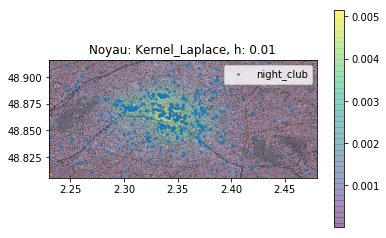

In [88]:
steps=40
Optimise_H(H,geo_mat,2,Kernel_Laplace,steps)

Observations:

On remarque que quand la valeur de steps augmente, la valeur de la densité calculé diminue. Par exemple pour steps=10, le maximum de la densité ( en jaune sur l'échelle ) est égale à 0,07. Tandis que pour steps=50, la valeur du maximum de la densité est égale à 0,005.

On peut observer aussi que la valeur de h ne varie pas beaucoup, on reste toujours dans l'orde de 0.01 pour h.

On peut aussi voir que la distribution de la densité ne change pas énormément lorsque la valeur de steps varie. Car sur les différentes maps obtenues ci-dissus, on peut voir à chaque fois, une  tâche jaune/bleu assez petite au millieu, et le reste en violet.La tâche au millieu n'a pas  l'air de s'élargir lorsque steps varie.

# Estimation de densité sur les données des Cafés

In [93]:
typepoi = "cafe"

geo_mat = np.zeros((len(poidata[typepoi]),2))

for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]

h: 0.0001  log vraissemblance: -137474.37980701978
h: 0.0002  log vraissemblance: -70809.84036699959
h: 0.001  log vraissemblance: -7966.099299773986
h: 0.002  log vraissemblance: -4701.863629472773
h: 0.01  log vraissemblance: -3740.11867306414
h: 0.02  log vraissemblance: -3763.1071664622773
h: 0.1  log vraissemblance: -4157.972816021778
h: 0.2  log vraissemblance: -4277.184857102073
h: 0.30000000000000004  log vraissemblance: -4307.675995790867
h: 0.4  log vraissemblance: -4319.0042472129835
h: 0.5  log vraissemblance: -4323.957037825734
h: 0.6  log vraissemblance: -4326.900910378759
h: 0.7000000000000001  log vraissemblance: -4328.62743032169
h: 0.8  log vraissemblance: -4329.667996011731
h: 0.9  log vraissemblance: -4330.541979409886
h: 0.060000000000000005  log vraissemblance: -3996.3352931726376
h: 0.015  log vraissemblance: -3691.4975077380577
h: 0.0175  log vraissemblance: -3725.5885812528336
h: 0.0125  log vraissemblance: -3709.7674836581155
h: 0.01375  log vraissemblance: -3

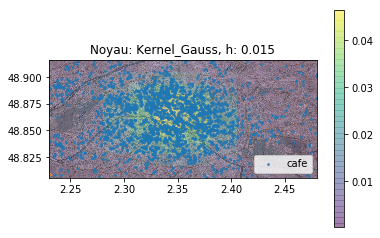

In [94]:
steps=10
Optimise_H(H,geo_mat,2,Kernel_Gauss,steps)

h: 0.0001  log vraissemblance: -123538.96057148986
h: 0.0002  log vraissemblance: -63804.7543535317
h: 0.001  log vraissemblance: -7372.599786279026
h: 0.002  log vraissemblance: -5474.8865328925085
h: 0.01  log vraissemblance: -4985.632539685253
h: 0.02  log vraissemblance: -5063.196085656171
h: 0.1  log vraissemblance: -5474.637541333855
h: 0.2  log vraissemblance: -5588.932970701881
h: 0.30000000000000004  log vraissemblance: -5615.101383142944
h: 0.4  log vraissemblance: -5624.435887686263
h: 0.5  log vraissemblance: -5629.355824484381
h: 0.6  log vraissemblance: -5632.032780698932
h: 0.7000000000000001  log vraissemblance: -5633.538101065974
h: 0.8  log vraissemblance: -5634.4384064461165
h: 0.9  log vraissemblance: -5635.31708824401
h: 0.060000000000000005  log vraissemblance: -5314.507823419015
h: 0.015  log vraissemblance: -5034.239034426301
h: 0.0175  log vraissemblance: -5033.88647747897
h: 0.0125  log vraissemblance: -4998.16092362258
h: 0.01375  log vraissemblance: -5057.08

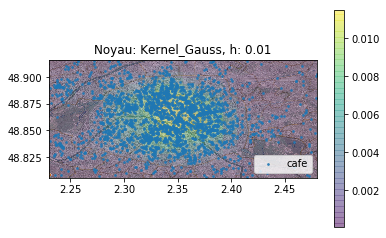

In [95]:
steps=20
Optimise_H(H,geo_mat,2,Kernel_Gauss,steps)

h: 0.0001  log vraissemblance: -123472.85671140206
h: 0.0002  log vraissemblance: -58623.73280364008
h: 0.001  log vraissemblance: -7801.706920831985
h: 0.002  log vraissemblance: -6214.3889944921675
h: 0.01  log vraissemblance: -5752.244166823207
h: 0.02  log vraissemblance: -5845.912475911246
h: 0.1  log vraissemblance: -6246.669505483249
h: 0.2  log vraissemblance: -6352.291784020235
h: 0.30000000000000004  log vraissemblance: -6377.93858774286
h: 0.4  log vraissemblance: -6388.093476836682
h: 0.5  log vraissemblance: -6392.539339133133
h: 0.6  log vraissemblance: -6395.222830423095
h: 0.7000000000000001  log vraissemblance: -6396.8021566424795
h: 0.8  log vraissemblance: -6397.773110526414
h: 0.9  log vraissemblance: -6398.570885037443
h: 0.060000000000000005  log vraissemblance: -6106.455147813527
h: 0.015  log vraissemblance: -5829.867495825141
h: 0.0175  log vraissemblance: -5829.035344569314
h: 0.0125  log vraissemblance: -5762.269096688094
h: 0.01375  log vraissemblance: -5853

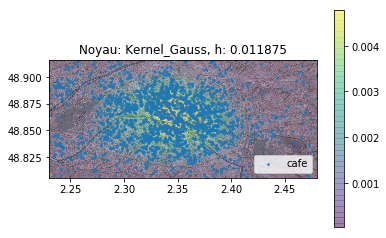

In [165]:
steps=30
Optimise_H(H,geo_mat,2,Kernel_Gauss,steps)

In [167]:
#steps=40
#Optimise_H(H,geo_mat,2,Kernel_Gauss,steps)

Observations:

On observe les mêmes tendeances que celle qu'on a observé précédemment sur les données des Nights Clubs

# Classification

Les notes des différents POI sont des variables continues ( ex:4.6 ,2.5 etc..). Je vais transformer notre problème en problème de classification (binaire avec deux classe -1 et 1).

In [100]:
print("max: ",max(labs))
print("min: ",min(labs))

max:  5.0
min:  -1.0


ON peut ramener cette étude à une classiification , c'est à dire que les points dont la note est inférieur à 2.5 seront associé au label -1 , tandis que ceux qui auront une note supérieur à 2.5 seront associé au label 1 (on transforme ça en une classification binaire). Ensuite on fera une crosse validation et, on mesurera l'efficacité de notre modèle selon différentes mesures(precision, rappel , score f1 si les donnéessont désiquilibré)).

Je décide de retirer les points dont la noté est -1 , car vu qu'on ne connait pas leur note , leur attribué la classe -1 ou 1 faussera l'évaluation.

In [101]:
geo_mat = np.zeros((len(poidata[typepoi]),2))
labs=[]

for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]
    labs.append(v[1])

labs=np.array(labs)
Y=[]
j=0
for i in range(0,len(geo_mat)):
    if (labs[i]==-1):
        geo_mat=np.delete(geo_mat,i-j,0)
        j+=1
    elif (labs[i]<=2.5):
        Y.append(-1)
    elif (labs[i]>2.5):
        Y.append(1)
        
Y=np.array(Y)

# KNN

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier


Dans un premier temps , on peut faire varier  le nombre de voisins.

In [103]:
X=geo_mat
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors)  #«uniforme»: poids uniformes. Tous les points de chaque quartier sont pondérés de manière égale.
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy') 
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.92 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.90 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.95 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 8
Accuracy Knn: 0.95 (+/- 0.00) neighbors: 9


In [104]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    scores = cross_val_score(knn, X, Y, cv=5, scoring='f1')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 4
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 6
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 7
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 8
Accuracy Knn: 0.98 (+/- 0.00) neighbors: 9


In [105]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors)
    scores = cross_val_score(knn, X, Y, cv=5, scoring='recall')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.93 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.98 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.99 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 6
Accuracy Knn: 1.00 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 8
Accuracy Knn: 1.00 (+/- 0.00) neighbors: 9


Pour une mesure en utilisant la mesure de rappel , on obtient de meilleur résultat. Et la mesure est d'autant meilleur que le nombre de voisin est grand.

Dans l'exemple précédent le poids était uniforme. On peut modifier le  paramètre weights en utilisant comme poids la «distance» : points de poids par l'inverse de leur distance. dans ce cas, les voisins les plus proches d'un point de requête auront une plus grande influence que les voisins plus éloignés.

In [106]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,weights='distance')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.92 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.92 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 5
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 8
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 9


In [107]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,weights='distance')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='f1')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.96 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 3
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 6
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 7
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 8
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 9


In [108]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,weights='distance')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='recall')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.96 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.98 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.98 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 5
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 8
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 9


Mieux vaut garder un poid uniforme  car définir un poid selon la distance entre les voisins a tendence a faire baisser la mesure.

On peut à présent changer la manière dont la distance est calculé (la métric ).

In [109]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,metric='euclidean')  # par default le poid est uniform
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.92 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.90 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.95 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 8
Accuracy Knn: 0.95 (+/- 0.00) neighbors: 9


In [110]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,metric='euclidean') 
    scores = cross_val_score(knn, X, Y, cv=5, scoring='f1')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 4
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 6
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 7
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 8
Accuracy Knn: 0.98 (+/- 0.00) neighbors: 9


In [111]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,metric='euclidean') 
    scores = cross_val_score(knn, X, Y, cv=5, scoring='recall')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.93 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.98 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.99 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 6
Accuracy Knn: 1.00 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 8
Accuracy Knn: 1.00 (+/- 0.00) neighbors: 9


In [112]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,metric='manhattan') 
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.92 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.90 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 5
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 8
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 9


In [113]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,metric='manhattan') 
    scores = cross_val_score(knn, X, Y, cv=5, scoring='f1')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 7
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 8
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 9


In [114]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,metric='manhattan') 
    scores = cross_val_score(knn, X, Y, cv=5, scoring='recall')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.93 (+/- 0.03) neighbors: 2
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.98 (+/- 0.01) neighbors: 4
Accuracy Knn: 1.00 (+/- 0.01) neighbors: 5
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 6
Accuracy Knn: 1.00 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.99 (+/- 0.00) neighbors: 8
Accuracy Knn: 1.00 (+/- 0.00) neighbors: 9


Les mesures ont tendance à resterles même sauf que l'incertitude augmente , donc aucune amélioration ici.

On peut également changer l'algorithme utilisé pour calculer les voisins les plus proches . Mais par défaut l'algoruthme utilisé est 'auto' et il tentera de décider l'algorithme le plus approprié en fonction des valeurs transmises à la fonction fit lors de l'entrainement.

In [115]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,algorithm='ball_tree')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='accuracy')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.92 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.90 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.94 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.95 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 6
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 8
Accuracy Knn: 0.95 (+/- 0.00) neighbors: 9


In [116]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,algorithm='ball_tree')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='f1')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.95 (+/- 0.01) neighbors: 2
Accuracy Knn: 0.97 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 4
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 6
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 7
Accuracy Knn: 0.97 (+/- 0.00) neighbors: 8
Accuracy Knn: 0.98 (+/- 0.00) neighbors: 9


In [117]:
for neighbors in range(1,10):
    knn = KNeighborsClassifier(n_neighbors=neighbors,algorithm='ball_tree')
    scores = cross_val_score(knn, X, Y, cv=5, scoring='recall')
    print("Accuracy Knn: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2), "neighbors:",neighbors)

Accuracy Knn: 0.96 (+/- 0.01) neighbors: 1
Accuracy Knn: 0.93 (+/- 0.02) neighbors: 2
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 3
Accuracy Knn: 0.98 (+/- 0.01) neighbors: 4
Accuracy Knn: 0.99 (+/- 0.00) neighbors: 5
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 6
Accuracy Knn: 1.00 (+/- 0.01) neighbors: 7
Accuracy Knn: 0.99 (+/- 0.01) neighbors: 8
Accuracy Knn: 1.00 (+/- 0.00) neighbors: 9


A priori l'argument auto a l'air de choisir l'algorithme approprié , vu qu'il n'y a pas d'améliarotion sur les scores en changeant d'algorithme ici.

# Nadaraya watson

La régression du noyau permet d'estimer l' espérance conditionnelle d'une variable aléatoire . L'objectif est de trouver une relation non linéaire entre une paire de variables aléatoires X et Y .

In [143]:
geo_mat = np.zeros((len(poidata[typepoi]),2))
labs=[]

for i,(k,v) in enumerate(poidata[typepoi].items()):
    geo_mat[i,:]=v[0]
    labs.append(v[1])

labs=np.array(labs)
Y=[]
j=0
for i in range(0,len(geo_mat)):
    if (labs[i]==-1):
        geo_mat=np.delete(geo_mat,i-j,0)
        j+=1
    elif (labs[i]<=2.5):
        Y.append(-1)
    elif (labs[i]>2.5):
        Y.append(1)
        
labs=np.array(Y)

In [146]:
def NadarayaW(grid,label,geomat,f,h,steps):
    n=len(geomat)
    m=np.zeros((len(grid)))
    for i in range(len(grid)):
        e=np.array([grid[i][1],grid[i][0]])
        d=0
        j=0
        for c in geomat: 
            v=f((c-e)/h)
            d+=v
            v=v*label[j]
            m[i]+=v
            j+=1
        m[i] /= d
    m = m.reshape((steps, steps))
    return m

In [148]:
steps=10
h=0.02

xx, yy = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
grid = np.c_[xx.ravel(), yy.ravel()]
m=NadarayaW(grid,labs,geo_mat,Kernel_Gauss,h,steps)

In [158]:
steps=20
h=0.02
xx, yy = np.meshgrid(np.linspace(xmin, xmax, steps), np.linspace(ymin, ymax, steps))
grid = np.c_[xx.ravel(), yy.ravel()]
X_train, X_test, y_train, y_test = train_test_split(geo_mat, labs, test_size=0.33, random_state=42)
m=NadarayaW(grid,y_train,X_train,Kernel_Gauss,h,steps)
X = np.linspace(xmin, xmax, steps)
Y = np.linspace(ymin, ymax, steps)

y_predict=[]
accuracy=0
for e in X_test:
    (x,y) = Search(X,Y,e,steps)
    v = m[x][y]
    y_predict.append(v)
    
y_p=[]
for i in range(0,len(y_predict)):
    y_p.append(np.sign(y_predict[i]))
    if (y_predict[i]>0 and y_test[i]==1):
        accuracy+=1
    elif (y_predict[i]<0 and y_test[i]==-1):
        accuracy+=1
        
accuracy=accuracy/len(y_test)
print("accuracy:",accuracy*100,"%")

L=[]
for i in range(0,len(y_p)):
    L.append([y_p[i],y_test[i]])
L=np.array(L)

df = pd.DataFrame(L, columns = ['note_predit', 'note_relle'])
df.head()  

accuracy: 94.43631039531479 %


,note_predit,note_relle
0,1.0,1.0
1,1.0,1.0
2,1.0,1.0
3,1.0,1.0
4,1.0,1.0
